# **Redes Recurrentes**


In [1]:
#import libreries

import tensorflow as tf
import numpy as np
import pandas as pd
import datasets 
import matplotlib.pyplot as plt

import keras 
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# -- Keras Import
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.preprocessing import image

from keras.datasets import imdb
from keras.datasets import mnist

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D

from keras.utils import np_utils
from keras.preprocessing import sequence
from keras_preprocessing.sequence import pad_sequences
from keras.layers import Embedding
from keras.layers import Bidirectional, LSTM, GRU, SimpleRNN

from keras.layers import Activation, TimeDistributed, RepeatVector
from keras.callbacks import EarlyStopping, ModelCheckpoint

from keras.layers import TextVectorization
from gensim.parsing.porter import PorterStemmer 
from gensim.parsing.preprocessing import remove_stopwords
import re
from keras.preprocessing.text import Tokenizer
import pickle

In [2]:
max_features = 20000
maxlen = 100  # cut texts after this number of words (among top max_features most common words)
batch_size = 32

print("Loading data...")

#download data
dataset = datasets.load_dataset('ucberkeley-dlab/measuring-hate-speech', 'binary')   

# Read data
df = dataset['train'].to_pandas()

df.head()


Loading data...


Using custom data configuration ucberkeley-dlab--measuring-hate-speech-1d47093687320b66
Reusing dataset parquet (C:\Users\Usuario\.cache\huggingface\datasets\ucberkeley-dlab___parquet\ucberkeley-dlab--measuring-hate-speech-1d47093687320b66\0.0.0\7328ef7ee03eaf3f86ae40594d46a1cec86161704e02dd19f232d81eee72ade8)


  0%|          | 0/1 [00:00<?, ?it/s]

,comment_id,annotator_id,platform,sentiment,respect,insult,humiliate,status,dehumanize,violence,...,annotator_religion_hindu,annotator_religion_jewish,annotator_religion_mormon,annotator_religion_muslim,annotator_religion_nothing,annotator_religion_other,annotator_sexuality_bisexual,annotator_sexuality_gay,annotator_sexuality_straight,annotator_sexuality_other
0,47777,10873,3,0.0,0.0,0.0,0.0,2.0,0.0,0.0,...,False,False,False,False,False,False,False,False,True,False
1,39773,2790,2,0.0,0.0,0.0,0.0,2.0,0.0,0.0,...,False,False,False,False,False,False,False,False,True,False
2,47101,3379,3,4.0,4.0,4.0,4.0,4.0,4.0,0.0,...,False,False,False,False,True,False,False,False,True,False
3,43625,7365,3,2.0,3.0,2.0,1.0,2.0,0.0,0.0,...,False,False,False,False,False,False,False,False,True,False
4,12538,488,0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,...,False,False,False,False,False,False,False,False,True,False


In [3]:
df.hatespeech.value_counts()

0.0    80624
2.0    46021
1.0     8911
Name: hatespeech, dtype: int64

In [4]:
def preprocessing(document: str) -> list:
    """
    convert text to lowercase
    remove no latin caracters 
    remove punctuation 
    remove extra spaces
    do stemming text
    """
    document = document.lower()
    document = remove_stopwords(document)
    document = re.sub('\n', ' ', document)
    document = re.sub('[^a-zA-Z]|[0-9]', ' ', document)
    document = re.sub('\s+', ' ', document)
    p = PorterStemmer()
    document = p.stem_sentence(document)
    return document

In [5]:
df['text']=df.text.apply(preprocessing)

In [6]:
X = df[['comment_id','annotator_id','platform','sentiment','respect','insult','humiliate','status','dehumanize','violence','genocide','attack_defend','hatespeech','hate_speech_score','text','infitms','outfitms','annotator_severity','std_err','annotator_infitms','annotator_outfitms','hypothesis','target_race_asian','target_race_black','target_race_latinx','target_race_middle_eastern','target_race_native_american','target_race_pacific_islander','target_race_white','target_race_other','target_race','target_religion_atheist','target_religion_buddhist','target_religion_christian','target_religion_hindu','target_religion_jewish','target_religion_mormon','target_religion_muslim','target_religion_other','target_religion','target_origin_immigrant','target_origin_migrant_worker','target_origin_specific_country','target_origin_undocumented','target_origin_other','target_origin','target_gender_men','target_gender_non_binary','target_gender_transgender_men','target_gender_transgender_unspecified','target_gender_transgender_women','target_gender_women','target_gender_other','target_gender','target_sexuality_bisexual','target_sexuality_gay','target_sexuality_lesbian','target_sexuality_straight','target_sexuality_other','target_sexuality','target_age_children','target_age_teenagers','target_age_young_adults','target_age_middle_aged','target_age_seniors','target_age_other','target_age','target_disability_physical','target_disability_cognitive','target_disability_neurological','target_disability_visually_impaired','target_disability_hearing_impaired','target_disability_unspecific','target_disability_other','target_disability','annotator_gender','annotator_trans','annotator_educ','annotator_income','annotator_ideology','annotator_gender_men','annotator_gender_women','annotator_gender_non_binary','annotator_gender_prefer_not_to_say','annotator_gender_self_describe','annotator_transgender','annotator_cisgender','annotator_transgender_prefer_not_to_say','annotator_education_some_high_school','annotator_education_high_school_grad','annotator_education_some_college','annotator_education_college_grad_aa','annotator_education_college_grad_ba','annotator_education_professional_degree','annotator_education_masters','annotator_education_phd','annotator_income_<10k','annotator_income_10k-50k','annotator_income_50k-100k','annotator_income_100k-200k','annotator_income_>200k','annotator_ideology_extremeley_conservative','annotator_ideology_conservative','annotator_ideology_slightly_conservative','annotator_ideology_neutral','annotator_ideology_slightly_liberal','annotator_ideology_liberal','annotator_ideology_extremeley_liberal','annotator_ideology_no_opinion','annotator_race_asian','annotator_race_black','annotator_race_latinx','annotator_race_middle_eastern','annotator_race_native_american','annotator_race_pacific_islander','annotator_race_white','annotator_race_other','annotator_age','annotator_religion_atheist','annotator_religion_buddhist','annotator_religion_christian','annotator_religion_hindu','annotator_religion_jewish','annotator_religion_mormon','annotator_religion_muslim','annotator_religion_nothing','annotator_religion_other','annotator_sexuality_bisexual','annotator_sexuality_gay','annotator_sexuality_straight','annotator_sexuality_other']]

y = df.hatespeech

In [7]:
X = df['text']
X

0         ye inde sort remind elder ladi plai movi titan...
1                        tran women read tweet right beauti
2         question broad critic america countri flee her...
3         time illeg countri origin freewai open prevent...
4         starter bend pink kick ass pussi tast she s be...
                                ...                        
135551    break new sayi abdulmalik the saudi regim lear...
135552    million yemen is particip mass ralli squar gov...
135553    abeshinzo realdonaldtrump shinzoab dictat goe ...
135554    million yemen is particip mass ralli squar gov...
135555    op hope commit suicid dai die ass cancer feel ...
Name: text, Length: 135556, dtype: object

### **Replace hatespeech == 1 with 2** 

In [8]:
# replace 1 with 2 in y
y = [1 if x==2 else x for x in y]

In [9]:
y = np.array(y)

### **Split in train and test data** 

In [10]:
X_train_validation, X_test, y_train_validation, y_test = train_test_split(X,y,
                                                    random_state=1,test_size=0.3)

X_train, X_validation, y_train, y_validation = train_test_split(X_train_validation, 
                                                    y_train_validation, 
                                                    random_state=1,test_size=0.33)

print('Number of rows in the total set: {}'.format(df.shape[0]))
print('Number of rows in the training set: {}'.format(len(X_train)))
print('Number of rows in the validation set: {}'.format(len(X_validation)))
print('Number of rows in the test set: {}'.format(len(X_test)))

Number of rows in the total set: 135556
Number of rows in the training set: 63575
Number of rows in the validation set: 31314
Number of rows in the test set: 40667


In [32]:
from keras_preprocessing import sequence

max_words = 20000
max_len = 150

word_token = Tokenizer(num_words=max_words)
word_token.fit_on_texts(X_train)
sequences = word_token.texts_to_sequences(X_train)
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)

In [12]:
sequences_matrix.shape[0]

63575

In [13]:
print('Build model...')

from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding

max_features = 20000
maxlen = 150 
batch_size = 32


model = Sequential()
model.add(Embedding(max_features, batch_size, input_length=maxlen))
model.add(LSTM(128))
model.add(Dropout(0.5))
model.add(Dense(64))
model.add(Dense(1))
model.add(Activation('sigmoid'))

Build model...


In [14]:
from tensorflow.keras.optimizers import RMSprop,Adam

#model = RNN()
model.summary()
model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 150, 32)           640000    
                                                                 
 lstm (LSTM)                 (None, 128)               82432     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
 activation (Activation)     (None, 1)                 0         
                                                                 
Total params: 730,753
Trainable params: 730,753
Non-trai

In [15]:
history = model.fit(sequences_matrix,y_train,batch_size=32,epochs=5,validation_split=0.2)

Epoch 1/5
1590/1590 [==============================] - 145s 91ms/step - loss: 0.4601 - accuracy: 0.7848 - val_loss: 0.4413 - val_accuracy: 0.7980
Epoch 2/5
1590/1590 [==============================] - 146s 92ms/step - loss: 0.4285 - accuracy: 0.8065 - val_loss: 0.4319 - val_accuracy: 0.8053
Epoch 3/5
1590/1590 [==============================] - 144s 91ms/step - loss: 0.4202 - accuracy: 0.8126 - val_loss: 0.4308 - val_accuracy: 0.8043
Epoch 4/5
1590/1590 [==============================] - 139s 87ms/step - loss: 0.4137 - accuracy: 0.8163 - val_loss: 0.4398 - val_accuracy: 0.8047
Epoch 5/5
1590/1590 [==============================] - 140s 88ms/step - loss: 0.4074 - accuracy: 0.8211 - val_loss: 0.4371 - val_accuracy: 0.8074


In [16]:
test_sequences = word_token.texts_to_sequences(X_test)
test_sequences_matrix = sequence.pad_sequences(test_sequences,maxlen=max_len)

In [17]:
accr = model.evaluate(test_sequences_matrix,y_test)

1271/1271 [==============================] - 39s 31ms/step - loss: 0.4393 - accuracy: 0.8059


In [18]:
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

Test set
  Loss: 0.439
  Accuracy: 0.806


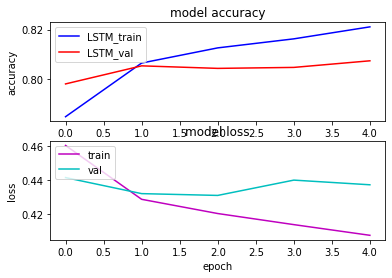

In [19]:
s, (at, al) = plt.subplots(2,1)
at.plot(history.history['accuracy'], c= 'b')
at.plot(history.history['val_accuracy'], c='r')
at.set_title('model accuracy')
at.set_ylabel('accuracy')
at.set_xlabel('epoch')
at.legend(['LSTM_train', 'LSTM_val'], loc='upper left')

al.plot(history.history['loss'], c='m')
al.plot(history.history['val_loss'], c='c')
al.set_title('model loss')
al.set_ylabel('loss')
al.set_xlabel('epoch')
al.legend(['train', 'val'], loc = 'upper left')

In [20]:
pickle.dump(word_token, open('salida/word_token.vector', 'wb'))

In [56]:
# Evaluación del modelo

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,  confusion_matrix, classification_report

max_words = 20000
max_len = 150

# word_token_test = Tokenizer(num_words=max_words)
# word_token_test.fit_on_texts(X_test)
sequences_test = word_token.texts_to_sequences(X_test)
sequences_matrix_test = sequence.pad_sequences(sequences_test,maxlen=max_len)

predictions = model.predict(sequences_matrix_test)

1271/1271 [==============================] - 31s 24ms/step


In [57]:
print('Accuracy score: ', format(accuracy_score(y_test, predictions.round())))
print('Precision score: ', format(precision_score(y_test, predictions.round())))
print('Recall score: ', format(recall_score(y_test, predictions.round())))
print('F1 score: ', format(f1_score(y_test, predictions.round())))

Accuracy score:  0.8058868369931395
Precision score:  0.7833699487384329
Recall score:  0.7171938806606936
F1 score:  0.7488227058673795


In [58]:
pred = model.predict(sequences_matrix_test)  
report = classification_report(y_test ,pred.round())  
print(report)
#En terminos de TP, FP, TN, FN
tn, fp, fn, tp = confusion_matrix(y_test, pred.round()).ravel()
(tn,fp,fn,tp)

1271/1271 [==============================] - 34s 27ms/step
              precision    recall  f1-score   support

         0.0       0.82      0.87      0.84     24260
         1.0       0.78      0.72      0.75     16407

    accuracy                           0.81     40667
   macro avg       0.80      0.79      0.80     40667
weighted avg       0.80      0.81      0.80     40667



(21006, 3254, 4640, 11767)

In [48]:
def get_hate_prediction(text):    
    serie_text = pd.Series([preprocessing(text)])
    sequences = word_token.texts_to_sequences(serie_text)
    sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)
    pred = model.predict(sequences_matrix)
    return 'Hate Speech' if pred[0][0] > 0.25 else 'Not Hate Speech'

In [55]:
get_hate_prediction('asshole')

1/1 [==============================] - 0s 22ms/step


'Hate Speech'

Persistencia del modelo:

In [27]:
model.save('salida/RNN_model')

INFO:tensorflow:Assets written to: salida/RNN_model\assets


INFO:tensorflow:Assets written to: salida/RNN_model\assets
